## **Multivariate Outlier Detection in Geochemical Datasets**
Author: Tyler Howe  
Last Updated: February 2025  

<br />
This notebook explores and compares three different methods of multivariate outlier detection in geochemical datasets, with a focus on applications in mineral exploration.  
<br />For this example, we use geochemical data gathered by the USGS from a region in southeastern Alaska, USA. All concentration values are reported in parts per million (ppm) for consistency.  


In [1]:
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import sklearn
import numpy as np

import helper_functions
import outlier_detection_functions

import importlib
importlib.reload(helper_functions)
importlib.reload(outlier_detection_functions)

print("SciPy Version:", scipy.__version__)
print("Scikit-learn Version:", sklearn.__version__)
print("NumPy Version:", np.__version__)

SciPy Version: 1.15.2
Scikit-learn Version: 1.6.1
NumPy Version: 2.2.3


In [2]:
df = pd.read_parquet("data_files/AK_raw_data.parquet")

In [28]:
df

,lab_id,Ba_ppm,Be_ppm,Co_ppm,Cr_ppm,Cu_ppm,La_ppm,Ni_ppm,Pb_ppm,Sc_ppm,Sr_ppm,V_ppm,Y_ppm,Zn_ppm,Zr_ppm,latitude,longitude
1152,ACE679,300.0,0.333333,30.0,150.0,70.0,6.666667,70.000000,3.333333,30.0,300.0,300.000000,30.0,66.666667,70.0,55.55250,-133.68028
1153,ACE680,150.0,0.333333,50.0,150.0,70.0,6.666667,70.000000,10.000000,30.0,300.0,300.000000,30.0,66.666667,70.0,55.54805,-133.65611
1154,ACE681,200.0,0.333333,15.0,30.0,20.0,6.666667,20.000000,3.333333,15.0,150.0,150.000000,10.0,66.666667,50.0,55.55305,-133.69333
1155,ACE682,150.0,0.333333,50.0,100.0,70.0,6.666667,50.000000,3.333333,30.0,300.0,300.000000,30.0,66.666667,70.0,55.55250,-133.71638
1156,ACE683,100.0,0.333333,20.0,30.0,30.0,6.666667,30.000000,3.333333,15.0,150.0,150.000000,10.0,66.666667,50.0,55.53027,-133.72972
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255442,W256663,1300.0,3.000000,1.0,2.4,4.0,45.300000,0.666667,12.000000,11.2,160.0,7.000000,58.0,127.000000,480.0,56.80000,-133.81667
255443,W256664,760.0,4.000000,0.6,1.3,2.0,42.900000,2.000000,20.000000,2.7,76.0,0.666667,33.0,44.000000,180.0,56.80000,-133.81667
255444,W256665,320.0,1.000000,39.8,21.0,34.0,15.000000,36.000000,9.000000,25.3,660.0,210.000000,19.0,262.000000,190.0,56.80000,-133.81667
255445,W256666,190.0,1.000000,43.5,241.0,34.0,9.450000,40.000000,1.333333,39.0,470.0,220.000000,31.0,90.000000,140.0,56.80000,-133.81667


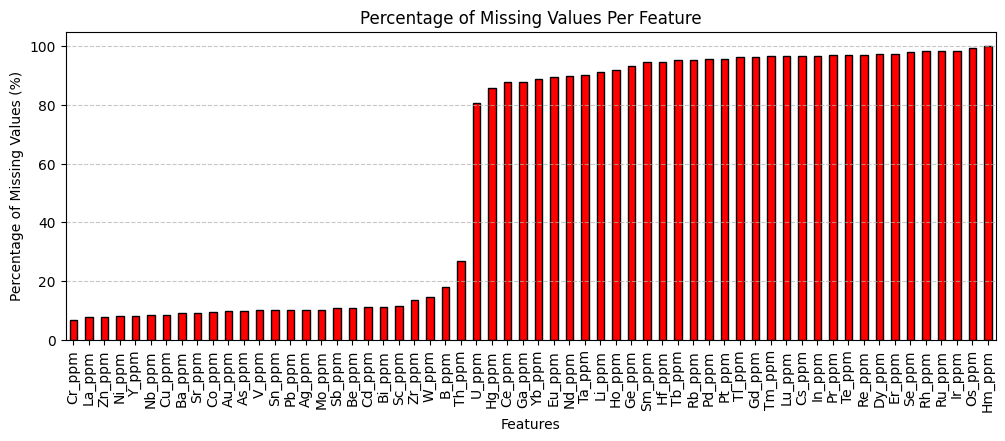

In [3]:
# Plot percentage of missing data in each column
helper_functions.plot_nan_percentage(df)

In [4]:
# Remove columns with more than 60% missing data and where the mode occurs in more than 40% of rows, fill missing data with median
df = helper_functions.clean_geochemical_data(df, nan_threshold=0.6, mode_threshold=0.4)
print(f"Columns in cleaned dataset: {df.columns}")

Dropped columns: Te_ppm, Li_ppm, Ce_ppm, Pd_ppm, B_ppm, Mo_ppm, W_ppm, Yb_ppm, Sm_ppm, Os_ppm, Pt_ppm, In_ppm, Pr_ppm, Cd_ppm, Hf_ppm, Ru_ppm, Se_ppm, Re_ppm, Tb_ppm, Tl_ppm, Ge_ppm, As_ppm, Nd_ppm, Rb_ppm, Sb_ppm, Ir_ppm, Ho_ppm, Hg_ppm, Gd_ppm, Bi_ppm, Ta_ppm, Lu_ppm, Au_ppm, Sn_ppm, Er_ppm, Ga_ppm, Th_ppm, Ag_ppm, Nb_ppm, Eu_ppm, Tm_ppm, Cs_ppm, U_ppm, Rh_ppm, Dy_ppm, Hm_ppm
Remaining NaNs filled with column medians.
Columns in cleaned dataset: Index(['lab_id', 'Ba_ppm', 'Be_ppm', 'Co_ppm', 'Cr_ppm', 'Cu_ppm', 'La_ppm',
       'Ni_ppm', 'Pb_ppm', 'Sc_ppm', 'Sr_ppm', 'V_ppm', 'Y_ppm', 'Zn_ppm',
       'Zr_ppm', 'latitude', 'longitude'],
      dtype='object')


In [5]:
# List of all geochemical columns to be used in the analysis - omits sample number and location columns
feature_columns = [
    col for col in df.columns if col not in ["lab_id", "latitude", "longitude"]
]

print(f"Selected feature columns: {feature_columns}")

Selected feature columns: ['Ba_ppm', 'Be_ppm', 'Co_ppm', 'Cr_ppm', 'Cu_ppm', 'La_ppm', 'Ni_ppm', 'Pb_ppm', 'Sc_ppm', 'Sr_ppm', 'V_ppm', 'Y_ppm', 'Zn_ppm', 'Zr_ppm']


### <u>Simple EDA on the data</u>

To start off, let's do a brief investigation into broad trends or relationships in the data to get a sense of what we are working with. 

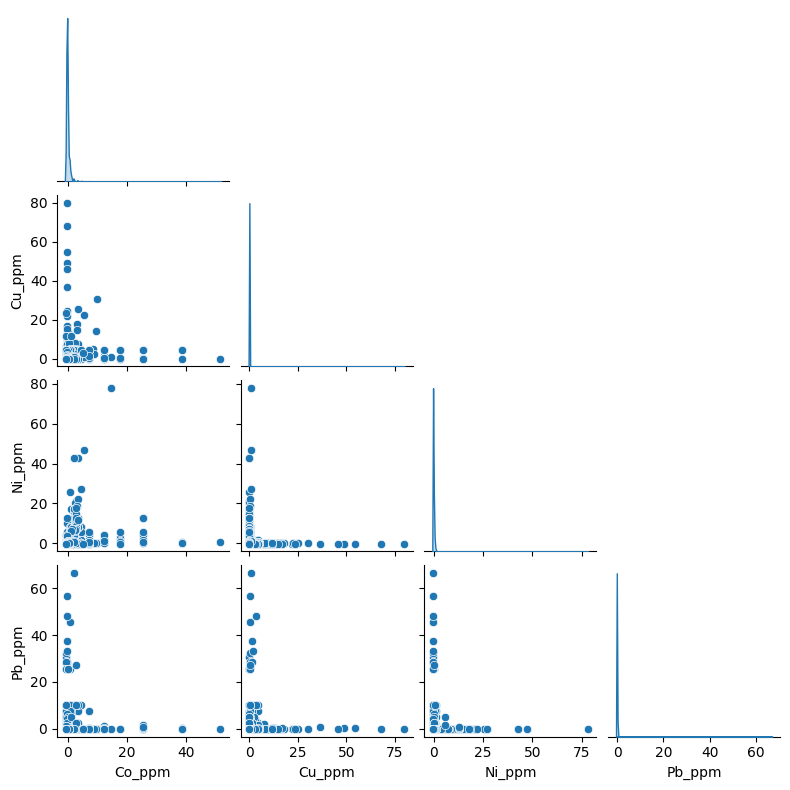

In [6]:
# Generate pairplot of select elements
elements_to_plot = ["Co_ppm", "Cu_ppm", "Ni_ppm", "Pb_ppm"]  # Choose key elements - ideally those related to mineralization or other interesting trends
helper_functions.generate_pairplot(df, elements_to_plot, height=2)

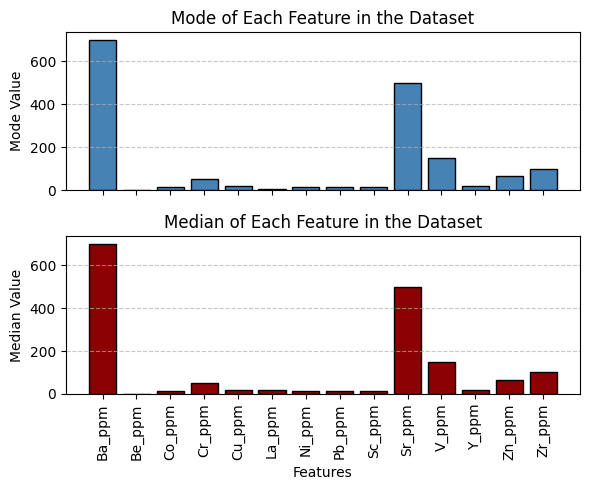

In [7]:
# Compute mode (first mode value) and median for each feature
helper_functions.plot_mode_median(df, feature_columns)

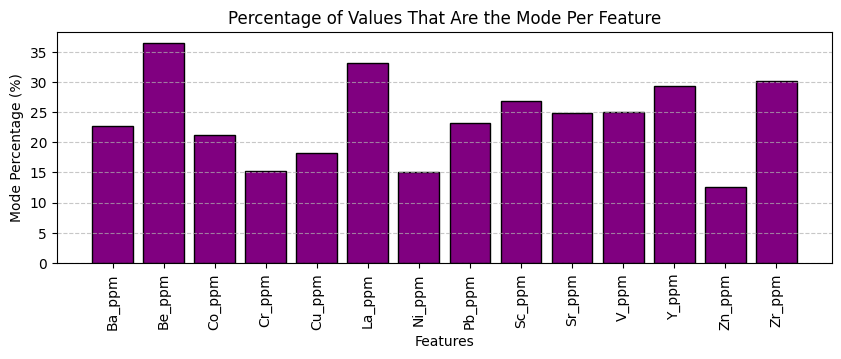

In [8]:
# Count number of modes per column
helper_functions.plot_mode_percentage(df, feature_columns)

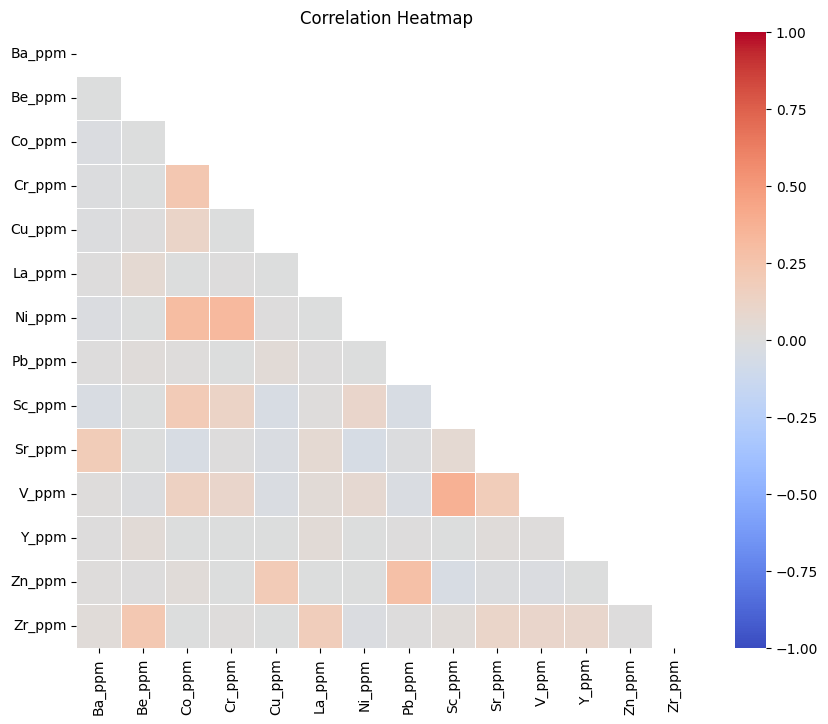

In [9]:
# Generate correlation heatmap
helper_functions.plot_correlation_heatmap(df, feature_columns, figsize=(10,8), annot=False) # Increase figsize to view all element labels

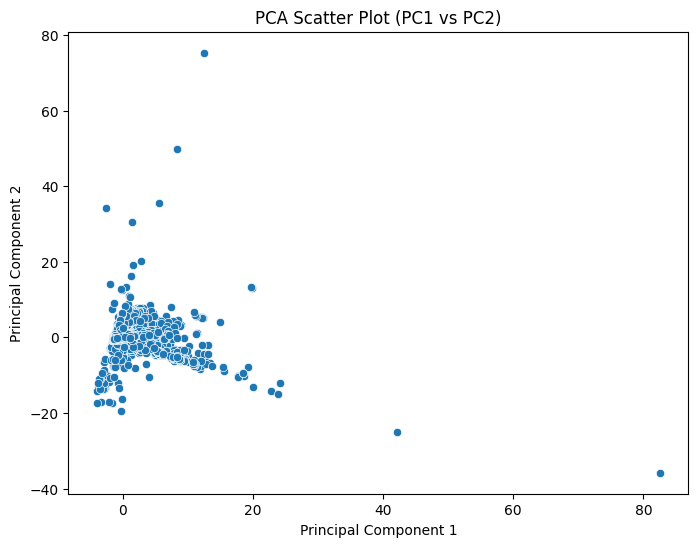

Top 5 Contributing Features to PC1: ['Co_ppm', 'Sc_ppm', 'Ni_ppm', 'Cr_ppm', 'V_ppm']
Top 5 Contributing Features to PC2: ['Zr_ppm', 'Sr_ppm', 'V_ppm', 'La_ppm', 'Ni_ppm']


In [10]:
# PCA
pc1_scores, top_features1, top_features2 = helper_functions.generate_pca(df, feature_columns)
print("Top 5 Contributing Features to PC1:", top_features1)
print("Top 5 Contributing Features to PC2:", top_features2)

---

## <u>Outlier Detection Methods</u>

Outliers in the binary plots below are classified using the Modified Z-Score method based on the Median Absolute Deviation (MAD). Data points with a modified Z-score greater than 3.5 are labeled as outliers (-1). This is done in place of the standard Contamination value, as it is hard to manually estimate the proportion of outliers in the datset. To modify the Z-score threshold, edit its default value at the top of the outlier_detection_functions.py file.

### <u>Isolation Forest</u>

Isolation forest is an unsupervised machine learning method of outlier/anomaly detection. It is an ensemble method that combines the predictions of several decision trees to assign an anomaly score to a given data point. Samples that require fewer splits across all trees are given a lower anomaly score (higher likelihood of being anomalous). This method of outlier detection is not affected by data distribution, but does require some parameter-tuning. 

In [11]:
IF_df = outlier_detection_functions.isolation_forest(
    df, feature_columns
)

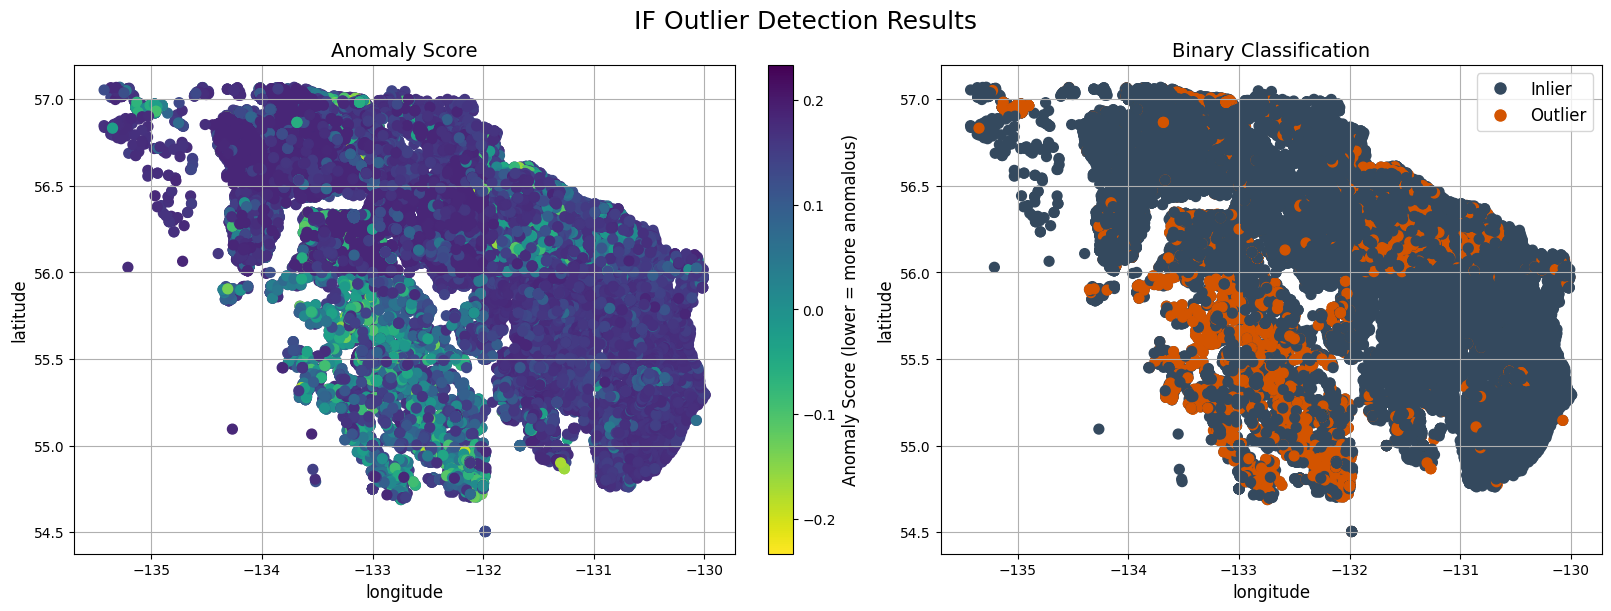

Classified 3415 outliers out of 30112 samples


In [12]:
# Plotting IF results
helper_functions.plot_outlier_results(
    data=IF_df,
    x_col="longitude",
    y_col="latitude",
    score_col="anomaly_score",
    binary_col="outlier",
    point_size=50,
    plot_title="IF Outlier Detection Results",
    cmap='viridis_r'
)


---

### <u>Local Outlier Factor</u>

LOF is another unsupervised outlier detection method that uses a density-based approach, comparing the density of data points in their local neighborhoods. Isolated samples or those on the margins of a neighborhood cluster will have a lower density than their neighbors. Samples with a lower LOF value are considered outliers. Similar to IF, LOF is unaffected by data distribution but does require some parameter-tuning.

In [13]:
LOF_df = outlier_detection_functions.local_outlier_factor(
    df, feature_columns, n_neighbors=50, scale_data=False
)

/Users/pablosoto/.local/share/virtualenvs/geochemical_anomaly_detection-n-a-hLHk/lib/python3.12/site-packages/sklearn/neighbors/_lof.py:322: UserWarning: Duplicate values are leading to incorrect results. Increase the number of neighbors for more accurate results.
  warnings.warn(


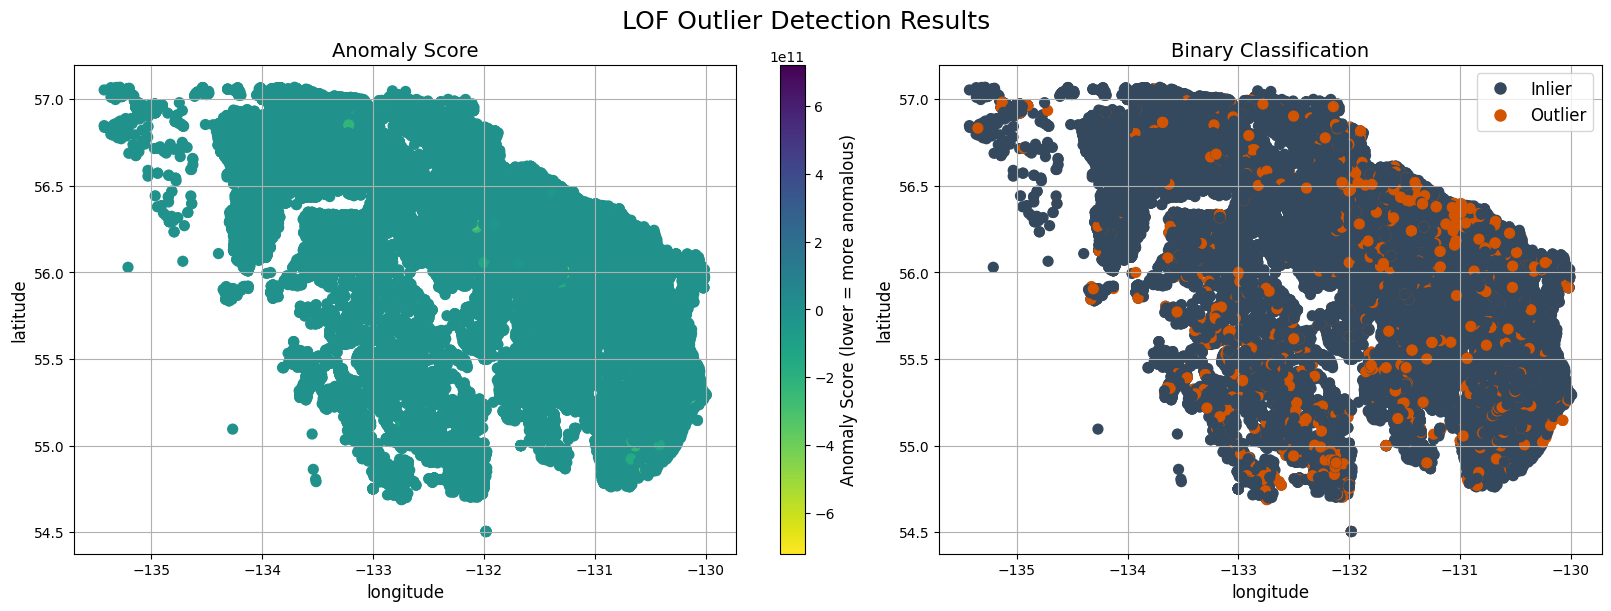

Classified 2371 outliers out of 30112 samples


In [14]:
# Plotting LOF results
helper_functions.plot_outlier_results(
    data=LOF_df,
    x_col="longitude",
    y_col="latitude",
    score_col="anomaly_score",
    binary_col="outlier",
    point_size=50,
    plot_title="LOF Outlier Detection Results",
    cmap="viridis_r",
)


---

### <u>Angle Based Outlier Detection</u>

Our final method of outlier detection is angle based outlier detection. This method compares the distribution of angles of distance vectors between a sample point and its neighbors; a point with a large distribution of vector angles is considered an inlier (within a cluster), while a point with a smaller distribution of angles is likely an outlier (outside a cluster). An angle-based score is then calculated, with less variation indicating a higher probability of the sample point being an outlier. One benefit of ABOD is that it is free of any parameters, and thus does not have the potential prediction variability resulting from tuning. Its implementation does not, however, output a binary classification, thus in order to generate one an arbitrary threshold must be defined. 

In [15]:
ABOD_df = outlier_detection_functions.abod(df, feature_columns, scale_data=True, use_knn=True, k_neighbors=100)

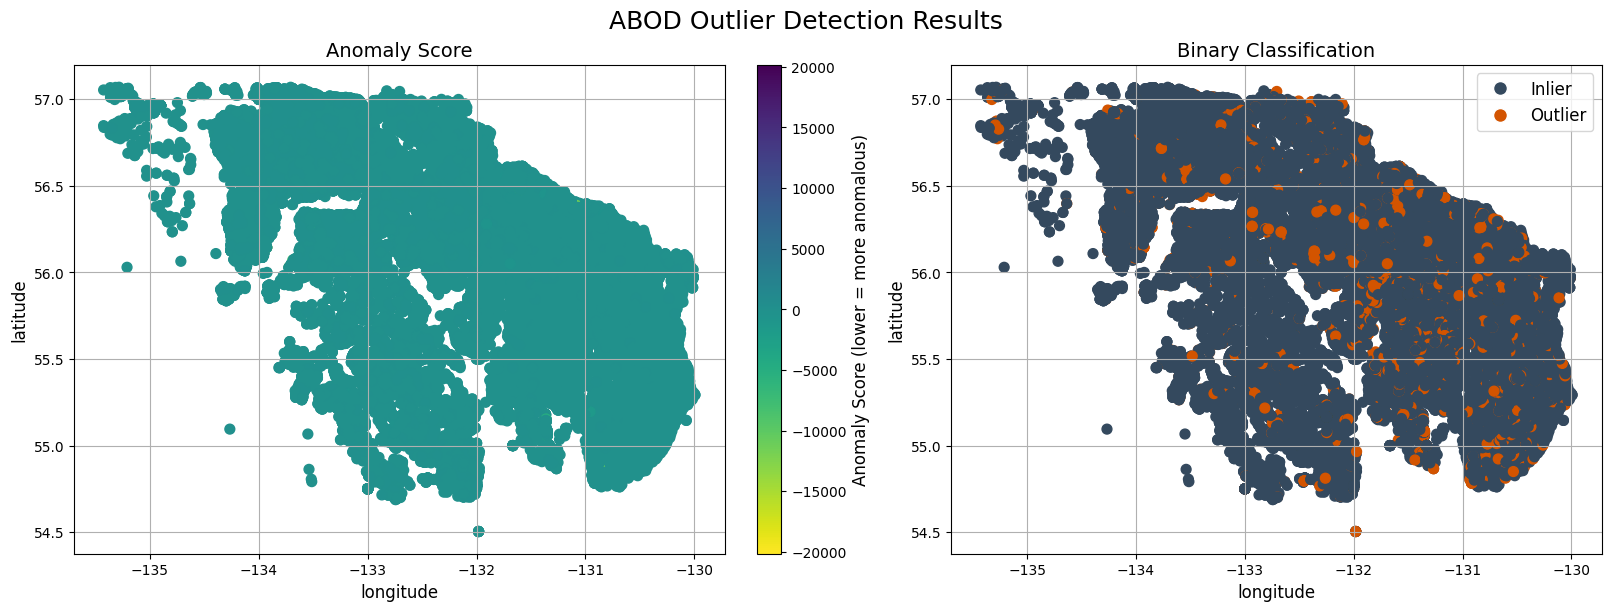

Classified 2869 outliers out of 30112 samples


In [16]:
# Plotting ABOD results
helper_functions.plot_outlier_results(
    data=ABOD_df,
    x_col="longitude",
    y_col="latitude",
    score_col="anomaly_score",
    binary_col="outlier",
    point_size=50,
    plot_title="ABOD Outlier Detection Results",
    cmap="viridis_r",
)

---

## <u>Validation of predictions</u>

Multivariate anomaly detection picks up on trends across multiple elements, rather than just single-element variation. As opposed to univariate anomalies that may be attributed to noise, sampling error, or highly-localized trends, multivariate analysis may point towards regions of broader geologic alteration related to mineral deposits. To test this relationship, we will compare outlier predictions from each model against known mineral occurrences in the sampling region. 

In [17]:
validation_df = pd.read_parquet('data_files/AK_validation.parquet')

### *Spatial validation of outlier predictions*

To start, we will conduct a visual analysis on the data, comparing binary outlier classifications vs. known mineral occurrences in the region.

Points detected as outliers by 1 model: 4560
Points detected as outliers by 2 models: 1125
Points detected as outliers by all 3 models: 72


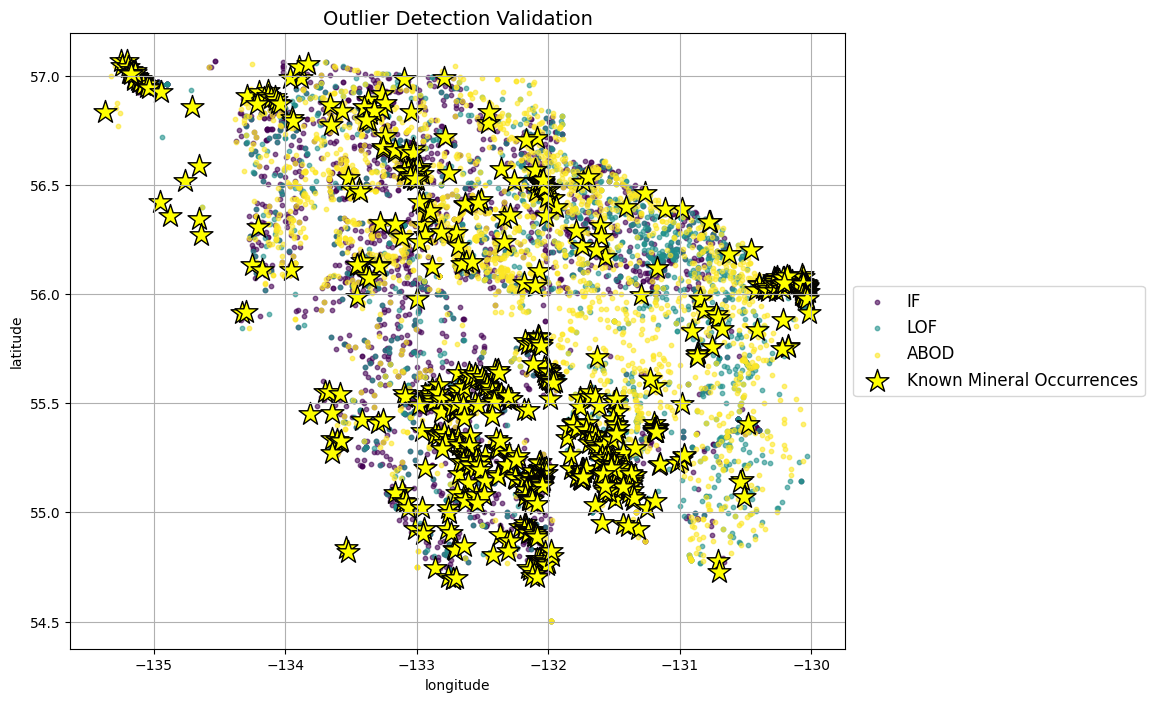

In [18]:
# Plot outlier detection results and validation dataset

outlier_results = [IF_df, LOF_df, ABOD_df]
outlier_result_names = ['IF', 'LOF', 'ABOD']

helper_functions.plot_validation(outlier_datasets=outlier_results, outlier_dataset_names=outlier_result_names, validation_df=validation_df, point_size=10, colormap='viridis', x_col='longitude', y_col='latitude')

---

### *ROC-AUC, ANOVA F-statistic, and Mutual Information scoring of outlier predictions*

To quantitatively compare the different outlier prediction methods, we will use three different scoring methods: ROC-AUC, ANOVA F-statistic, and Mutual Information.
<br />
<br />
- *<u>ROC-AUC, or Receiver Operating Characteristic Area Under the Curve</u>* is a machine learning metric used to evaluate a model's ability to distinguish between positive and negative classes; a score of 1 is considered 'perfect,' or that the model gets 100% of predictions correct. 
    - Generally best for evaluating overall predictive performance, regardless of spatial location.
<br />
<br />
- The *<u>ANOVA F-statistic</u>* is a method of comparing the variances of two samples (in this case the prediction and the validation set); the higher the score, the greater the model's predictions are differentiated. That is, there is a meaningful pattern between predicted outliers and known mineral deposits.
    - Measures how well the model distinguishes spatially relevant anomalies.
<br />
<br />
- *<u>Mutual Information</u>* is a method of measuring how much information one variable provides about another, or how dependent they are on each other. Higher MI values indicate stronger relationships between variables. 
    - Quantifies dependency between outlier predictions and proximity to known deposits.


*Note: due to the large sample size of the dataset and the way that F- and MI scores are calculated, the results from these two are skewed.*

ROC-AUC Score for IF: 0.6876
ROC-AUC Score for LOF: 0.6539
ROC-AUC Score for ABOD: 0.3979
F-Score for IF: 1027.0057
F-Score for LOF: 3.3922
F-Score for ABOD: 0.7265
Mutual Information Score for IF: 0.0081
Mutual Information Score for LOF: 0.0061
Mutual Information Score for ABOD: 0.0000


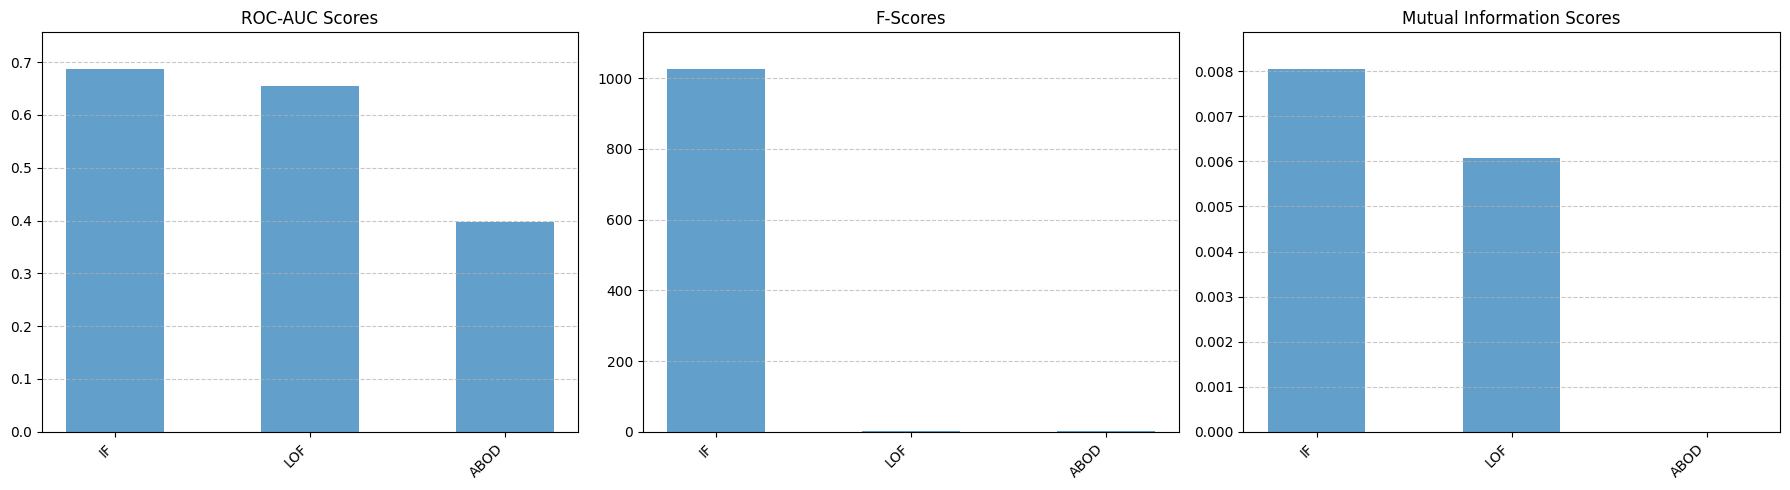

In [19]:
# Calculate scores for each outlier detection method

scoring_radius = 0.005 # roughly 500m

roc_auc_scores = helper_functions.calculate_roc_auc(
    outlier_results,
    outlier_result_names,
    validation_df,
    radius=scoring_radius,
    x_col="longitude",
    y_col="latitude",
)

f_scores = helper_functions.calculate_f_score(
    outlier_results,
    outlier_result_names,
    validation_df,
    radius=scoring_radius,
    x_col="longitude",
    y_col="latitude",
)

mi_scores = helper_functions.calculate_mi_score(
    outlier_results,
    outlier_result_names,
    validation_df,
    radius=scoring_radius,
    x_col="longitude",
    y_col="latitude",
)

helper_functions.plot_scores(
    [roc_auc_scores, f_scores, mi_scores],
    titles=["ROC-AUC Scores", "F-Scores", "Mutual Information Scores"],
)

---

### *Deeper investigation into ROC-AUC scoring of each model*

Lets create a ROC curve for each model to better understand the way that they are performing compared to each other. 

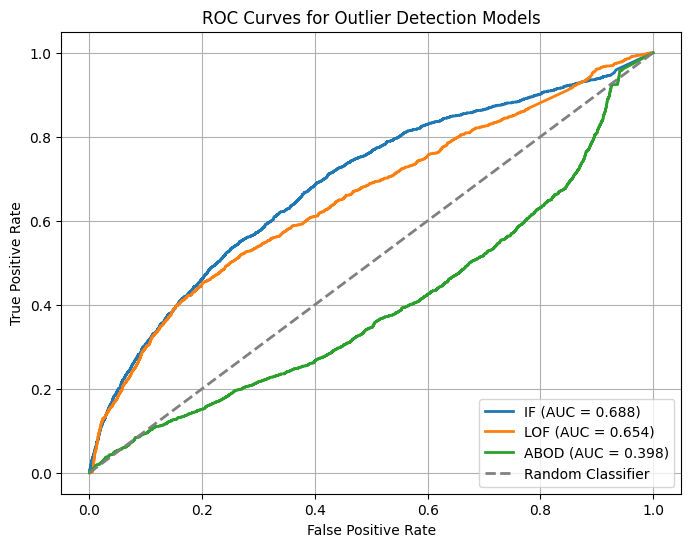

In [20]:
helper_functions.plot_roc_curves(
    outlier_datasets=outlier_results,  # Your outlier model DataFrames
    outlier_dataset_names=outlier_result_names,  # Names of models
    validation_df=validation_df,  # Known mineral deposits
    radius=scoring_radius,
    x_col='longitude', 
    y_col='latitude'
)

The ROC curve above generally matches the results we observed in the first peek into model performance - IF best optimizes the TPR/FPR ratio, closely followed by LOF. ABOD actually skews towards the false positive side of the graph. This may be due to the fact that we are utilizing k-nearest neighbors to optimize its processing time. Unfortunately, at least on the system this code was created on, to process the full dataset would take approx. 250 hours, which is not feasible for this analysis. Further investigation into the effects of kNN on model accuracy is needed. 

---

### <u>Time Cost Analysis</u>

Given the significant time-cost differences between models, it is important to consider how they compare relative to model accuracy; IF and LOF process almost instantly, while ABOD takes some time due to the nature of the calculation. For relatively small datasets, the time cost of ABOD is minimal, but for larger datasets the tradeoffs should be considered; it may be more efficient to use an algorithm like Isolation Forest.

Below we will do a brief investigation into the time cost of each method, focusing particularly on ABOD.

In [21]:
outlier_models = [
    outlier_detection_functions.isolation_forest,
    outlier_detection_functions.local_outlier_factor,
    lambda df, feature_columns: outlier_detection_functions.abod(
        df, feature_columns, use_knn=True, k_neighbors=50
    ),
]

outlier_model_names = ["IF", "LOF", "ABOD"]
scoring_radius = 0.005

# Dictionary to store results
results = {"Model": [], "Iteration": [], "Execution Time (s)": [], "ROC-AUC Score": []}

for model, name in zip(outlier_models, outlier_model_names):
    for i in range(7):
        start = time.time()
        output_df = model(df, feature_columns)  # abod will be called with use_knn=True
        end = time.time()
        exec_time = end - start

        print(f"{name} iteration {i} took {exec_time} seconds")

        roc_auc_score = helper_functions.calculate_roc_auc(
            outlier_datasets=[output_df],
            outlier_dataset_names=[name],
            validation_df=validation_df,
            radius=scoring_radius,
            x_col="longitude",
            y_col="latitude",
        )[name]

        # Store results in dictionary
        results["Model"].append(name)
        results["Iteration"].append(i)
        results["Execution Time (s)"].append(exec_time)
        results["ROC-AUC Score"].append(roc_auc_score)

IF iteration 0 took 0.18803000450134277 seconds
ROC-AUC Score for IF: 0.6876
IF iteration 1 took 0.14981985092163086 seconds
ROC-AUC Score for IF: 0.6876
IF iteration 2 took 0.1581439971923828 seconds
ROC-AUC Score for IF: 0.6876
IF iteration 3 took 0.15091609954833984 seconds
ROC-AUC Score for IF: 0.6876
IF iteration 4 took 0.15252280235290527 seconds
ROC-AUC Score for IF: 0.6876
IF iteration 5 took 0.15183305740356445 seconds
ROC-AUC Score for IF: 0.6876
IF iteration 6 took 0.1492609977722168 seconds
ROC-AUC Score for IF: 0.6876


/Users/pablosoto/.local/share/virtualenvs/geochemical_anomaly_detection-n-a-hLHk/lib/python3.12/site-packages/sklearn/neighbors/_lof.py:322: UserWarning: Duplicate values are leading to incorrect results. Increase the number of neighbors for more accurate results.
  warnings.warn(


LOF iteration 0 took 2.221426248550415 seconds
ROC-AUC Score for LOF: 0.6430


/Users/pablosoto/.local/share/virtualenvs/geochemical_anomaly_detection-n-a-hLHk/lib/python3.12/site-packages/sklearn/neighbors/_lof.py:322: UserWarning: Duplicate values are leading to incorrect results. Increase the number of neighbors for more accurate results.
  warnings.warn(


LOF iteration 1 took 2.230772018432617 seconds
ROC-AUC Score for LOF: 0.6430


/Users/pablosoto/.local/share/virtualenvs/geochemical_anomaly_detection-n-a-hLHk/lib/python3.12/site-packages/sklearn/neighbors/_lof.py:322: UserWarning: Duplicate values are leading to incorrect results. Increase the number of neighbors for more accurate results.
  warnings.warn(


LOF iteration 2 took 2.1436500549316406 seconds
ROC-AUC Score for LOF: 0.6430


/Users/pablosoto/.local/share/virtualenvs/geochemical_anomaly_detection-n-a-hLHk/lib/python3.12/site-packages/sklearn/neighbors/_lof.py:322: UserWarning: Duplicate values are leading to incorrect results. Increase the number of neighbors for more accurate results.
  warnings.warn(


LOF iteration 3 took 2.147066116333008 seconds
ROC-AUC Score for LOF: 0.6430


/Users/pablosoto/.local/share/virtualenvs/geochemical_anomaly_detection-n-a-hLHk/lib/python3.12/site-packages/sklearn/neighbors/_lof.py:322: UserWarning: Duplicate values are leading to incorrect results. Increase the number of neighbors for more accurate results.
  warnings.warn(


LOF iteration 4 took 2.1460161209106445 seconds
ROC-AUC Score for LOF: 0.6430


/Users/pablosoto/.local/share/virtualenvs/geochemical_anomaly_detection-n-a-hLHk/lib/python3.12/site-packages/sklearn/neighbors/_lof.py:322: UserWarning: Duplicate values are leading to incorrect results. Increase the number of neighbors for more accurate results.
  warnings.warn(


LOF iteration 5 took 2.1425869464874268 seconds
ROC-AUC Score for LOF: 0.6430


/Users/pablosoto/.local/share/virtualenvs/geochemical_anomaly_detection-n-a-hLHk/lib/python3.12/site-packages/sklearn/neighbors/_lof.py:322: UserWarning: Duplicate values are leading to incorrect results. Increase the number of neighbors for more accurate results.
  warnings.warn(


LOF iteration 6 took 2.137151002883911 seconds
ROC-AUC Score for LOF: 0.6430
ABOD iteration 0 took 4.728825092315674 seconds   100%
ROC-AUC Score for ABOD: 0.3934
ABOD iteration 1 took 4.662611246109009 seconds   100%
ROC-AUC Score for ABOD: 0.3934
ABOD iteration 2 took 4.646458148956299 seconds   100%
ROC-AUC Score for ABOD: 0.3934
ABOD iteration 3 took 4.639217853546143 seconds   100%
ROC-AUC Score for ABOD: 0.3934
ABOD iteration 4 took 4.642661094665527 seconds   100%
ROC-AUC Score for ABOD: 0.3934
ABOD iteration 5 took 4.69697380065918 seconds    100%
ROC-AUC Score for ABOD: 0.3934
ABOD iteration 6 took 4.700507164001465 seconds   100%
ROC-AUC Score for ABOD: 0.3934


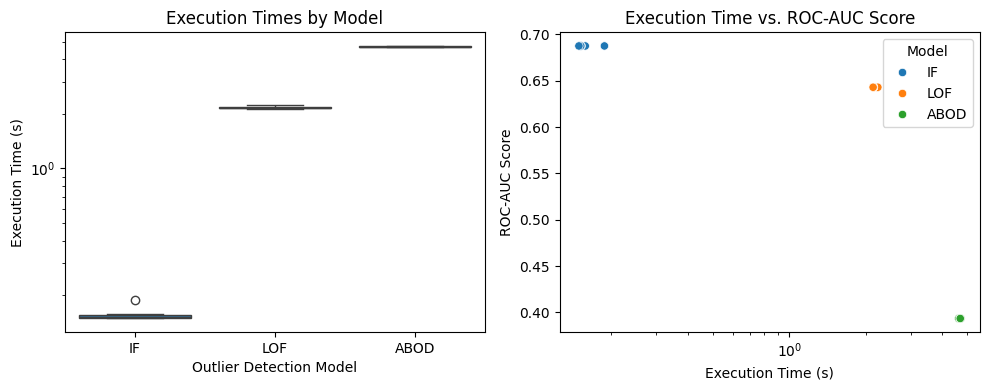

In [25]:
# Plot the results of the above analysis

results_df = pd.DataFrame(results)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Box Plot
sns.boxplot(x="Model", y="Execution Time (s)", data=results_df, ax=axes[0])
axes[0].set_title("Execution Times by Model")
axes[0].set_xlabel("Outlier Detection Model")
axes[0].set_ylabel("Execution Time (s)")
axes[0].set_yscale("log")

# Scatter Plot
sns.scatterplot(
    x="Execution Time (s)", y="ROC-AUC Score", hue="Model", data=results_df, ax=axes[1]
)
axes[1].set_title("Execution Time vs. ROC-AUC Score")
axes[1].set_xlabel("Execution Time (s)")
axes[1].set_xscale("log")
axes[1].set_ylabel("ROC-AUC Score")
axes[1].legend(title="Model")

plt.tight_layout()
plt.show()

As we can see in the above plots, IF has both a lower execution time as well as higher ROC-AUC score than LOF, which is then significantly faster and more accurate than ABOD. Given this, it does not seem practical to utilize LOF or ABOD, at least in the context of the given dataset. It is important to note that the ABOD function run in this analysis utilizes kNN downsampling to speed up processing times, which may have an impact on model accuracy.

In [26]:
# Analyze the execution time of each method with varying sample sizes

# Define sample sizes
sample_sizes = [50, 100, 200, 400, 800]

# Measure execution time
abod_results_df = helper_functions.measure_model_execution(
    df, sample_sizes, model=outlier_detection_functions.abod
)

if_results_df = helper_functions.measure_model_execution(
    df, sample_sizes, model=outlier_detection_functions.isolation_forest
)

lof_results_df = helper_functions.measure_model_execution(
    df, sample_sizes, model=outlier_detection_functions.local_outlier_factor
)



Processed 50 samples in 0.0150 seconds using abod
Processed 100 samples in 0.0150 seconds using abod
Processed 200 samples in 0.0624 seconds using abod
Processed 400 samples in 0.3620 seconds using abod
Processed 800 samples in 4.0910 seconds using abod
Processed 50 samples in 0.0723 seconds using isolation_forest
Processed 100 samples in 0.0548 seconds using isolation_forest
Processed 200 samples in 0.0549 seconds using isolation_forest
Processed 400 samples in 0.0583 seconds using isolation_forest
Processed 800 samples in 0.0576 seconds using isolation_forest
Processed 50 samples in 0.0147 seconds using local_outlier_factor
Processed 100 samples in 0.0035 seconds using local_outlier_factor
Processed 200 samples in 0.0034 seconds using local_outlier_factor
Processed 400 samples in 0.0043 seconds using local_outlier_factor
Processed 800 samples in 0.0055 seconds using local_outlier_factor


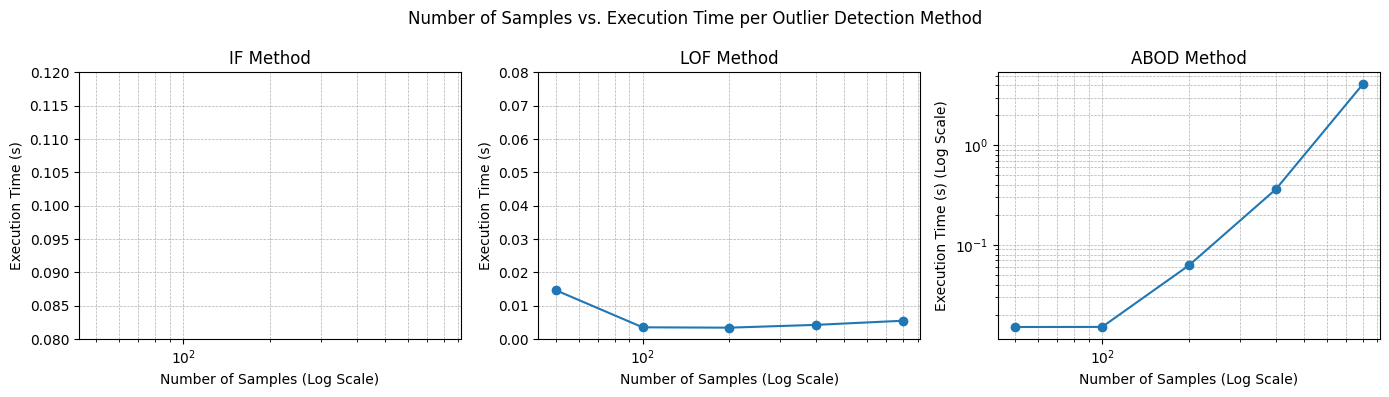

In [27]:
# Plot the results
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# IF
axes[0].plot(
    if_results_df["Number of Samples"],
    if_results_df["Execution Time (s)"],
    marker="o",
    linestyle="-",
)
axes[0].set_xlabel("Number of Samples (Log Scale)")
axes[0].set_xscale("log")  
axes[0].set_ylabel("Execution Time (s)")
axes[0].set_ylim(0.08, 0.12)
axes[0].set_title("IF Method")
axes[0].grid(True, which="both", linestyle="--", linewidth=0.5)

# LOF
axes[1].plot(
    lof_results_df["Number of Samples"],
    lof_results_df["Execution Time (s)"],
    marker="o",
    linestyle="-",
)
axes[1].set_xlabel("Number of Samples (Log Scale)")
axes[1].set_xscale("log")  
axes[1].set_ylabel("Execution Time (s)")
axes[1].set_ylim(0, 0.08)
axes[1].set_title("LOF Method")
axes[1].grid(True, which="both", linestyle="--", linewidth=0.5)

## ABOD
axes[2].plot(
   abod_results_df["Number of Samples"],
   abod_results_df["Execution Time (s)"],
   marker="o",
   linestyle="-",
)
axes[2].set_xscale("log")
axes[2].set_yscale("log")
axes[2].set_xlabel("Number of Samples (Log Scale)")
axes[2].set_ylabel("Execution Time (s) (Log Scale)")
axes[2].set_title("ABOD Method")
axes[2].grid(True, which="both", linestyle="--", linewidth=0.5)

fig.suptitle("Number of Samples vs. Execution Time per Outlier Detection Method")
plt.tight_layout()
plt.show()

As we can see above, ABOD has more similar execution times as IF/LOF (<1s) when n<~200, but beyond that the time cost grows exponentially. IF and LOF distributions are irregular due to the extremely short processing times, and variation can be attributed to random noise; they generally follow an O(n) time complexity, while ABOD appears to follow O(n^2), which aligns with the pairwise computations required to calculate ABOD. 

To summarize, for the purpose of analyzing this dataset (or any large dataset n>~10000), IF is the clear choice to best balance processing time and model accuracy. 